In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

figsize(16, 9)

Populating the interactive namespace from numpy and matplotlib


Load the data.

In [2]:
sunspots = pd.read_csv('monthly_sunspots.csv')['Sunspots']

Remove the linear trend from the series.

In [3]:
x = np.arange(len(sunspots))
poly_coeffs = np.polyfit(x, sunspots, 1)
poly = polyval(poly_coeffs, x)
sunspots_detrend = sunspots - poly

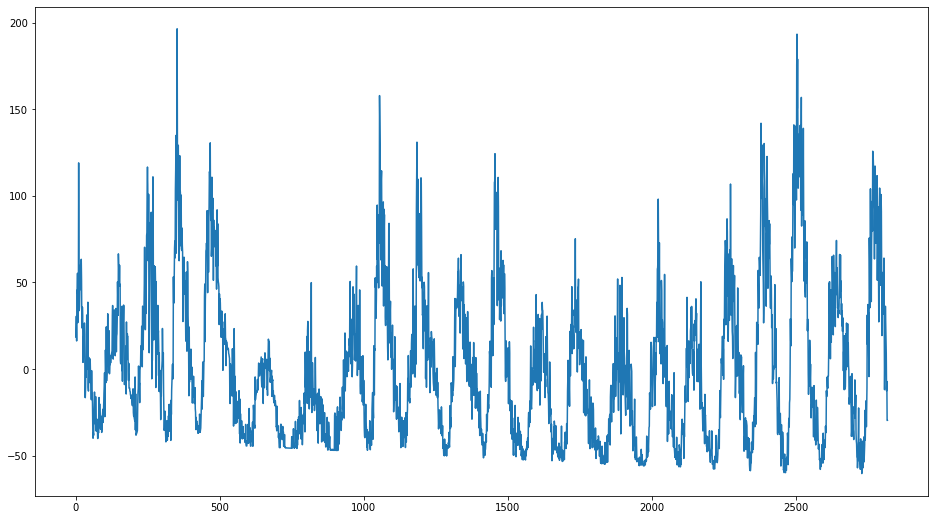

In [4]:
plt.plot(sunspots_detrend)

Split the series into train and test parts.

In [5]:
split_point = int(len(sunspots)*0.8)
sunspots_train = sunspots_detrend[:split_point]
sunspots_test = sunspots_detrend[split_point:]

We use $\mathrm{SARIMA}(3, 0, 2)(0, 1, 0)_{128}$, which was identified by trial and error to give the best results. 128 month (~10.7 years) periods are the solar cycles.

In [6]:
model = sm.tsa.arima.ARIMA(sunspots_train, order=(3, 0, 2), seasonal_order=(0, 1, 0, 128))
model = model.fit(method='innovations_mle', low_memory=True, cov_type='none')

/home/akonstantinov/.apps/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/arima/model.py:340: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  ' estimation by method "%s".' % method)


In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Sunspots   No. Observations:                 2256
Model:             ARIMA(3, 0, 2)x(0, 1, [], 125)   Log Likelihood               -9458.736
Date:                            Tue, 05 Jan 2021   AIC                          18929.471
Time:                                    20:40:15   BIC                          18963.457
Sample:                                         0   HQIC                         18941.910
                                           - 2256                                         
Covariance Type:                             none                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2857        nan        nan        nan         nan         nan
ar.L2         -1.6338        nan        nan        nan         nan         nan
ar.L3          0.3450        nan        nan        nan         nan         nan
ma.L1         -1.7739        nan        nan        nan         nan         nan
ma.L2          0.8051        nan        nan        nan         nan         nan
sigma2       419.2977        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       65.72   Jarque-Bera (JB):               536.82
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

Compare the fitted values and the actual train part of the time series.

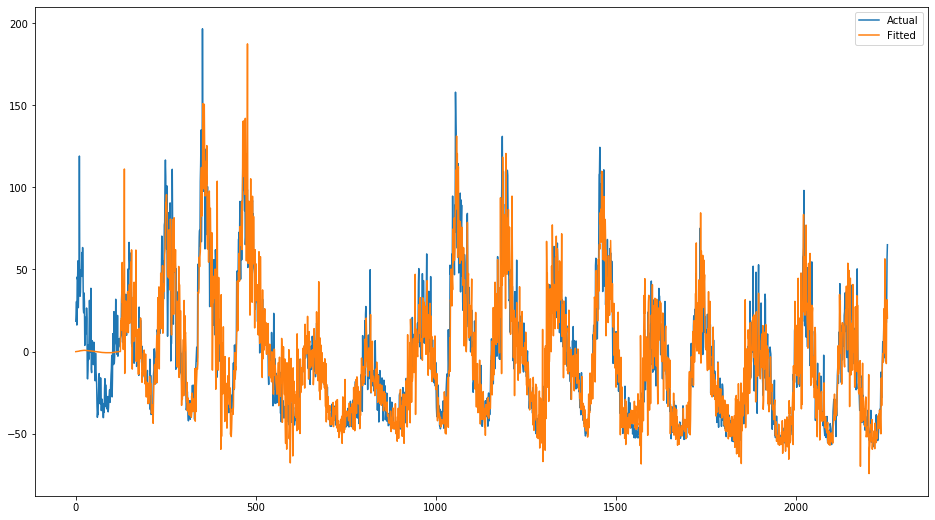

In [8]:
plt.figure(figsize=(16,9))
plt.plot(sunspots_train, label='Actual')
plt.plot(model.fittedvalues, label='Fitted')
plt.legend()

Test the model and evaluate the forecast against the actual future.

MAPE: 0.6025884839063652


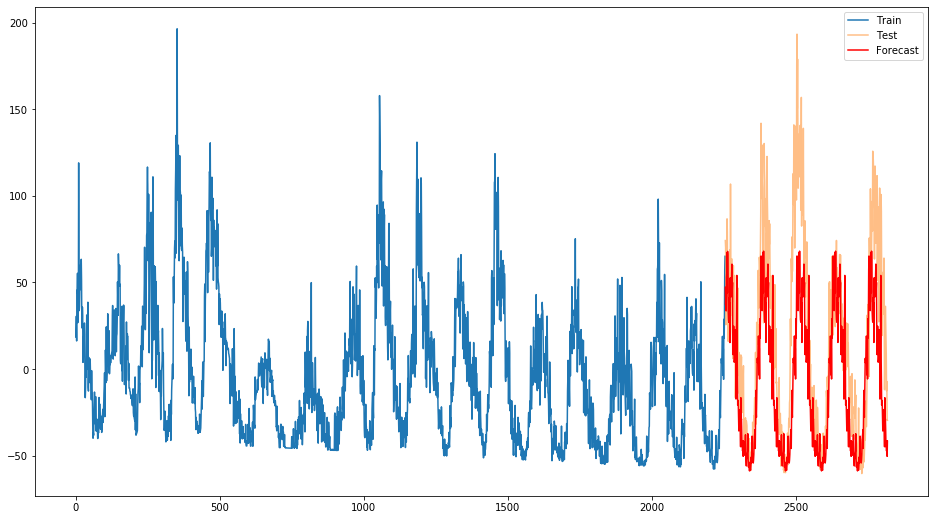

In [9]:
plt.figure(figsize=(16, 9))

start = len(sunspots_train)
end = len(sunspots_train) + len(sunspots_test)

x = np.arange(start, end)
sunspots_forecast = model.predict(start=start, end=end-1)

plt.plot(sunspots_train, label='Train')
plt.plot(x, sunspots_test, label='Test', alpha=0.5)
plt.plot(x, sunspots_forecast, label='Forecast', color='red')
plt.legend()

# median here to compensate for some division by almost zero values
sunspots_mape = np.median(np.abs((sunspots_test - sunspots_forecast)/sunspots_test))
print(f'MAPE: {sunspots_mape}')